In [6]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import cv2
import os
import pandas as pd
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score

In [7]:
# ----------------------------
# 1. DATA PREPROCESSING FUNCTIONS 
# ----------------------------
def preprocess_image(img, target_size=(224, 224)):
    img = cv2.resize(img, target_size)
    if img.dtype != np.uint8:
        img = (img * 255).astype(np.uint8)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    closed = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel)
    mask = cv2.threshold(closed, 10, 255, cv2.THRESH_BINARY_INV)[1].astype(np.uint8)
    inpainted = cv2.inpaint(img, mask, 1, cv2.INPAINT_TELEA)
    norm_img = inpainted.astype("float32") / 255.0
    return norm_img

In [8]:
# ----------------------------
# 2. CONFIGURATION
# ----------------------------
ROOT_DIR = "/kaggle/input/resized300sccaksekmelbccnvmeldermsekonly/resized"
BATCH_SIZE = 32
EPOCHS = 25  # Increased epochs for better training
LEARNING_RATE = 5e-5  # Lower learning rate for fine-tuning
CHECKPOINT_PATH = "/kaggle/working/best_model_xception.pth"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# ----------------------------
# 3. DATA PREPROCESSING
# ----------------------------
transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Xception requires 299x299 input
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomAffine(degrees=0, shear=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

dataset = datasets.ImageFolder(ROOT_DIR, transform=transform)
num_classes = len(dataset.classes)
print(f"Number of classes: {num_classes}")

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

Number of classes: 9


In [9]:
import torch
import torch.nn as nn
import timm

class XceptionModel(nn.Module):
    def __init__(self, num_classes):
        super(XceptionModel, self).__init__()
        self.model = timm.create_model("xception", pretrained=True)  # Load pretrained Xception
        in_features = self.model.fc.in_features  # Get last layer size
        self.model.fc = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.model(x)
# Example usage:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 9  # Change based on your dataset
model = XceptionModel(num_classes=num_classes).to(DEVICE)
print(model)  # Verify the model architecture

XceptionModel(
  (model): Xception(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act2): ReLU(inplace=True)
    (block1): Block(
      (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (rep): Sequential(
        (0): SeparableConv2d(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
          (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inpla

In [10]:
# ----------------------------
# 5. INITIALIZATION
# ----------------------------
model = XceptionModel(num_classes=num_classes).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# ----------------------------
# 6. TRAINING & EVALUATION
# ----------------------------
best_train_acc = 0
metrics = []

for epoch in range(EPOCHS):
    model.train()
    train_loss, correct, total = 0, 0, 0
    train_preds, train_labels = [], []

    with tqdm(train_loader, unit="batch") as tepoch:
        for images, labels in tepoch:
            tepoch.set_description(f"Epoch {epoch+1}")
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * labels.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

            tepoch.set_postfix(loss=train_loss/total, accuracy=100.*correct/total)

    train_acc = 100. * correct / total
    avg_train_loss = train_loss / total

    if train_acc > best_train_acc:
        best_train_acc = train_acc
        torch.save(model.state_dict(), CHECKPOINT_PATH)
        print("Checkpoint saved!")

    # ----------------------------
    # 7. VALIDATION STEP
    # ----------------------------
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    val_preds, val_labels = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * labels.size(0)
            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / val_total
    val_acc = 100. * val_correct / val_total

    # Compute additional metrics
    train_precision = precision_score(train_labels, train_preds, average='weighted')
    train_recall = recall_score(train_labels, train_preds, average='weighted')
    train_f1 = f1_score(train_labels, train_preds, average='weighted')
    
    val_precision = precision_score(val_labels, val_preds, average='weighted')
    val_recall = recall_score(val_labels, val_preds, average='weighted')
    val_f1 = f1_score(val_labels, val_preds, average='weighted')

    metrics.append([epoch+1, avg_train_loss, train_acc, train_precision, train_recall, train_f1,
                    avg_val_loss, val_acc, val_precision, val_recall, val_f1])

    print(f"Epoch {epoch+1}: Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

# Save metrics to CSV
columns = ["Epoch", "Train Loss", "Train Accuracy", "Train Precision", "Train Recall", "Train F1-Score",
           "Val Loss", "Val Accuracy", "Val Precision", "Val Recall", "Val F1-Score"]
metrics_df = pd.DataFrame(metrics, columns=columns)
metrics_df.to_csv("metrics_xception.csv", index=False)
print("Metrics saved to metrics_xception.csv")

Epoch 1: 100%|██████████| 575/575 [09:41<00:00,  1.01s/batch, accuracy=69.3, loss=0.856]


Checkpoint saved!


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1: Train Acc: 69.28% | Val Acc: 79.42%


Epoch 2: 100%|██████████| 575/575 [09:14<00:00,  1.04batch/s, accuracy=82.5, loss=0.476]


Checkpoint saved!
Epoch 2: Train Acc: 82.52% | Val Acc: 85.10%


Epoch 3: 100%|██████████| 575/575 [09:14<00:00,  1.04batch/s, accuracy=86.2, loss=0.368]


Checkpoint saved!
Epoch 3: Train Acc: 86.18% | Val Acc: 86.14%


Epoch 4: 100%|██████████| 575/575 [09:15<00:00,  1.03batch/s, accuracy=88.2, loss=0.313]


Checkpoint saved!
Epoch 4: Train Acc: 88.17% | Val Acc: 87.34%


Epoch 5: 100%|██████████| 575/575 [09:14<00:00,  1.04batch/s, accuracy=90.2, loss=0.267]


Checkpoint saved!
Epoch 5: Train Acc: 90.18% | Val Acc: 87.23%


Epoch 6: 100%|██████████| 575/575 [09:16<00:00,  1.03batch/s, accuracy=91.2, loss=0.236]


Checkpoint saved!
Epoch 6: Train Acc: 91.15% | Val Acc: 87.99%


Epoch 7: 100%|██████████| 575/575 [09:19<00:00,  1.03batch/s, accuracy=91.9, loss=0.213]


Checkpoint saved!
Epoch 7: Train Acc: 91.95% | Val Acc: 87.25%


Epoch 8: 100%|██████████| 575/575 [09:23<00:00,  1.02batch/s, accuracy=93.1, loss=0.187]


Checkpoint saved!
Epoch 8: Train Acc: 93.12% | Val Acc: 88.80%


Epoch 9: 100%|██████████| 575/575 [09:25<00:00,  1.02batch/s, accuracy=94.1, loss=0.165]


Checkpoint saved!
Epoch 9: Train Acc: 94.05% | Val Acc: 88.30%


Epoch 10: 100%|██████████| 575/575 [09:26<00:00,  1.01batch/s, accuracy=94.5, loss=0.15] 


Checkpoint saved!
Epoch 10: Train Acc: 94.49% | Val Acc: 88.78%


Epoch 11: 100%|██████████| 575/575 [09:22<00:00,  1.02batch/s, accuracy=95, loss=0.133]  


Checkpoint saved!
Epoch 11: Train Acc: 94.95% | Val Acc: 88.69%


Epoch 12: 100%|██████████| 575/575 [09:24<00:00,  1.02batch/s, accuracy=95.4, loss=0.123]


Checkpoint saved!
Epoch 12: Train Acc: 95.43% | Val Acc: 89.01%


Epoch 13: 100%|██████████| 575/575 [09:24<00:00,  1.02batch/s, accuracy=96.1, loss=0.111]


Checkpoint saved!
Epoch 13: Train Acc: 96.09% | Val Acc: 89.56%


Epoch 14: 100%|██████████| 575/575 [09:25<00:00,  1.02batch/s, accuracy=96.3, loss=0.101] 


Checkpoint saved!
Epoch 14: Train Acc: 96.31% | Val Acc: 89.49%


Epoch 15: 100%|██████████| 575/575 [09:30<00:00,  1.01batch/s, accuracy=96.6, loss=0.0947]


Checkpoint saved!
Epoch 15: Train Acc: 96.57% | Val Acc: 89.71%


Epoch 16: 100%|██████████| 575/575 [09:28<00:00,  1.01batch/s, accuracy=96.8, loss=0.0887]


Checkpoint saved!
Epoch 16: Train Acc: 96.79% | Val Acc: 89.21%


Epoch 17: 100%|██████████| 575/575 [09:27<00:00,  1.01batch/s, accuracy=97.2, loss=0.0766]


Checkpoint saved!
Epoch 17: Train Acc: 97.23% | Val Acc: 89.84%


Epoch 18: 100%|██████████| 575/575 [09:26<00:00,  1.02batch/s, accuracy=97.4, loss=0.0726]


Checkpoint saved!
Epoch 18: Train Acc: 97.38% | Val Acc: 89.62%


Epoch 19: 100%|██████████| 575/575 [09:24<00:00,  1.02batch/s, accuracy=97.4, loss=0.0698]


Checkpoint saved!
Epoch 19: Train Acc: 97.45% | Val Acc: 89.36%


Epoch 20: 100%|██████████| 575/575 [09:27<00:00,  1.01batch/s, accuracy=97.8, loss=0.0627]


Checkpoint saved!
Epoch 20: Train Acc: 97.75% | Val Acc: 90.12%


Epoch 21: 100%|██████████| 575/575 [09:27<00:00,  1.01batch/s, accuracy=97.8, loss=0.0605]


Epoch 21: Train Acc: 97.75% | Val Acc: 89.45%


Epoch 22: 100%|██████████| 575/575 [09:31<00:00,  1.01batch/s, accuracy=97.9, loss=0.0618]


Checkpoint saved!
Epoch 22: Train Acc: 97.86% | Val Acc: 90.36%


Epoch 23: 100%|██████████| 575/575 [09:24<00:00,  1.02batch/s, accuracy=98.3, loss=0.0491]


Checkpoint saved!
Epoch 23: Train Acc: 98.34% | Val Acc: 89.99%


Epoch 24: 100%|██████████| 575/575 [09:24<00:00,  1.02batch/s, accuracy=98.3, loss=0.0515]


Epoch 24: Train Acc: 98.27% | Val Acc: 90.10%


Epoch 25:  90%|████████▉ | 516/575 [08:26<00:58,  1.00batch/s, accuracy=98.3, loss=0.0503]

Epoch 25: Train Acc: 98.23% | Val Acc: 89.60%
Metrics saved to metrics_xception.csv


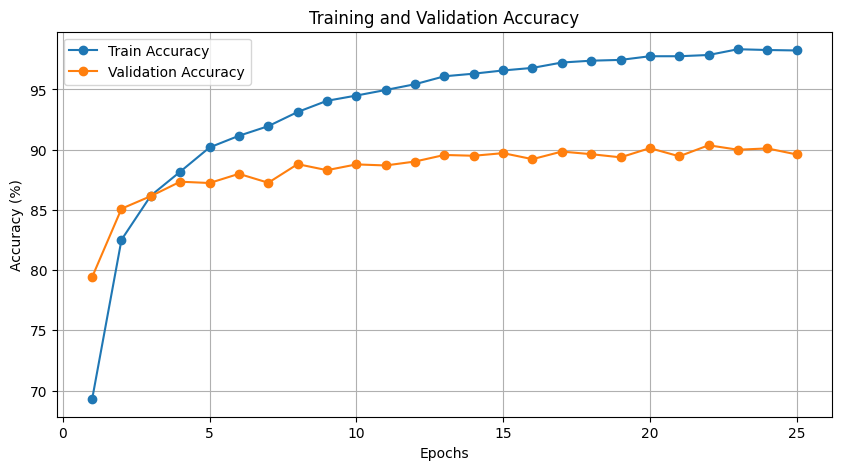

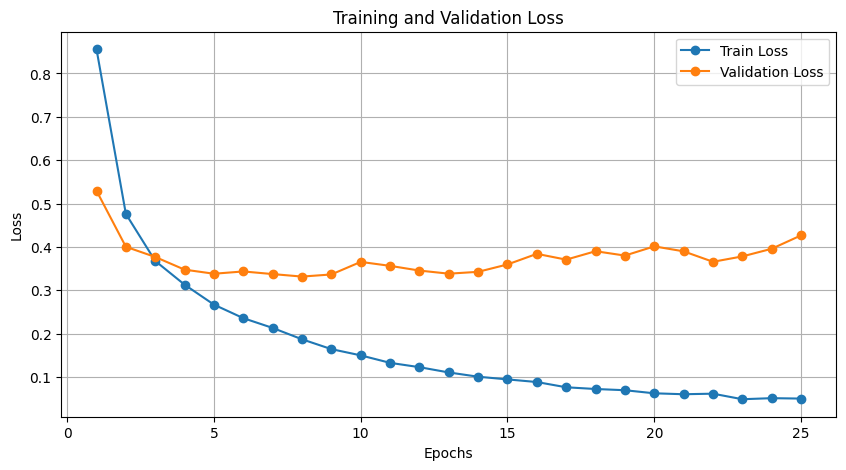

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the saved metrics
df = pd.read_csv("metrics_xception.csv")

# Visualization for Accuracy
plt.figure(figsize=(10, 5))
plt.plot(df['Epoch'], df['Train Accuracy'], label='Train Accuracy', marker='o')
plt.plot(df['Epoch'], df['Val Accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()
# Visualization for Loss
plt.figure(figsize=(10, 5))
plt.plot(df['Epoch'], df['Train Loss'], label='Train Loss', marker='o')
plt.plot(df['Epoch'], df['Val Loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch

def evaluate_model(model, dataloader, class_names=None):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Classification report
    print("\nClassification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Precision, Recall, F1
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    accuracy = np.mean(all_preds == all_labels)

    print(f"\nAccuracy: {accuracy * 100:.2f}%")
    print(f"Precision (weighted): {precision:.4f}")
    print(f"Recall (weighted):    {recall:.4f}")
    print(f"F1 Score (weighted):  {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names if class_names else range(num_classes),
                yticklabels=class_names if class_names else range(num_classes))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()


/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(



Classification Report:

              precision    recall  f1-score   support

          AK       0.96      0.93      0.94       852
        Acne       1.00      1.00      1.00      2538
         BCC       0.96      0.97      0.96      2457
          DF       0.95      0.94      0.95       203
         MEL       0.95      0.97      0.96      4797
          NV       0.98      0.97      0.98      8763
         SCC       0.96      0.92      0.94       628
         SEK       0.98      0.98      0.98      2491
        VASC       0.98      0.94      0.96       253

    accuracy                           0.97     22982
   macro avg       0.97      0.96      0.96     22982
weighted avg       0.97      0.97      0.97     22982


Accuracy: 97.17%
Precision (weighted): 0.9718
Recall (weighted):    0.9717
F1 Score (weighted):  0.9717


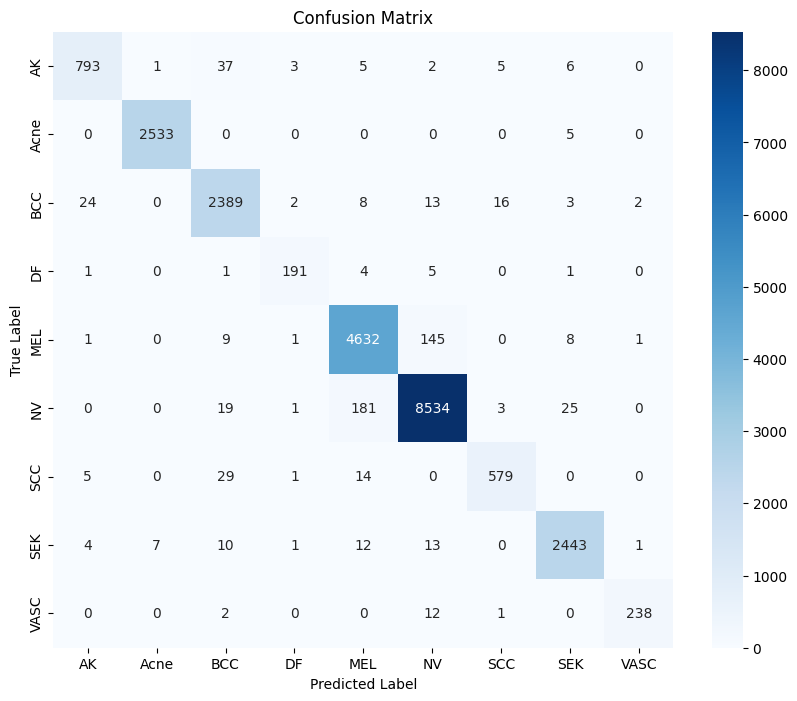

In [14]:
# Load the best model for evaluation

val_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)
# Class names (optional, shown on CM axes)
class_names = dataset.classes  # if you want actual class names in the matrix
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 9  # Change based on your dataset
model = XceptionModel(num_classes=num_classes).to(DEVICE)
CHECKPOINT_PATH="/kaggle/working/best_model_xception.pth"
model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=DEVICE,weights_only=True))
model.to(DEVICE)
# Evaluate on validation data
evaluate_model(model, val_loader, class_names)


In [21]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_roc_pr_curves(model, dataloader, class_names):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(DEVICE)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            all_probs.append(probs)
            all_labels.append(labels.cpu().numpy())

    all_probs = np.vstack(all_probs)
    all_labels = np.hstack(all_labels)

    # Binarize the labels for multi-class ROC & PR curves
    y_true_bin = label_binarize(all_labels, classes=np.arange(len(class_names)))
    n_classes = len(class_names)

    # ----------------------------
    # ROC CURVE
    # ----------------------------
    fpr, tpr, roc_auc = dict(), dict(), dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(12, 6))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.title("ROC Curve (One-vs-Rest)")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ----------------------------
    # PRECISION-RECALL CURVE
    # ----------------------------
    precision, recall, avg_precision = dict(), dict(), dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], all_probs[:, i])
        avg_precision[i] = average_precision_score(y_true_bin[:, i], all_probs[:, i])

    plt.figure(figsize=(12, 6))
    for i in range(n_classes):
        plt.plot(recall[i], precision[i], label=f'{class_names[i]} (AP = {avg_precision[i]:.2f})')

    plt.title("Precision-Recall Curve (One-vs-Rest)")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


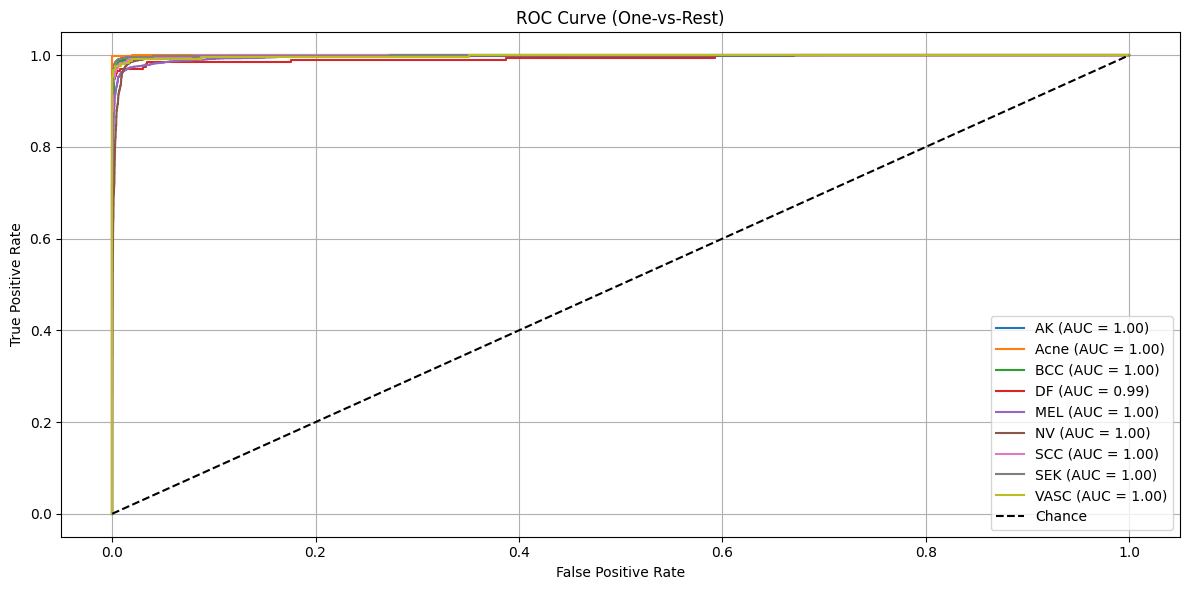

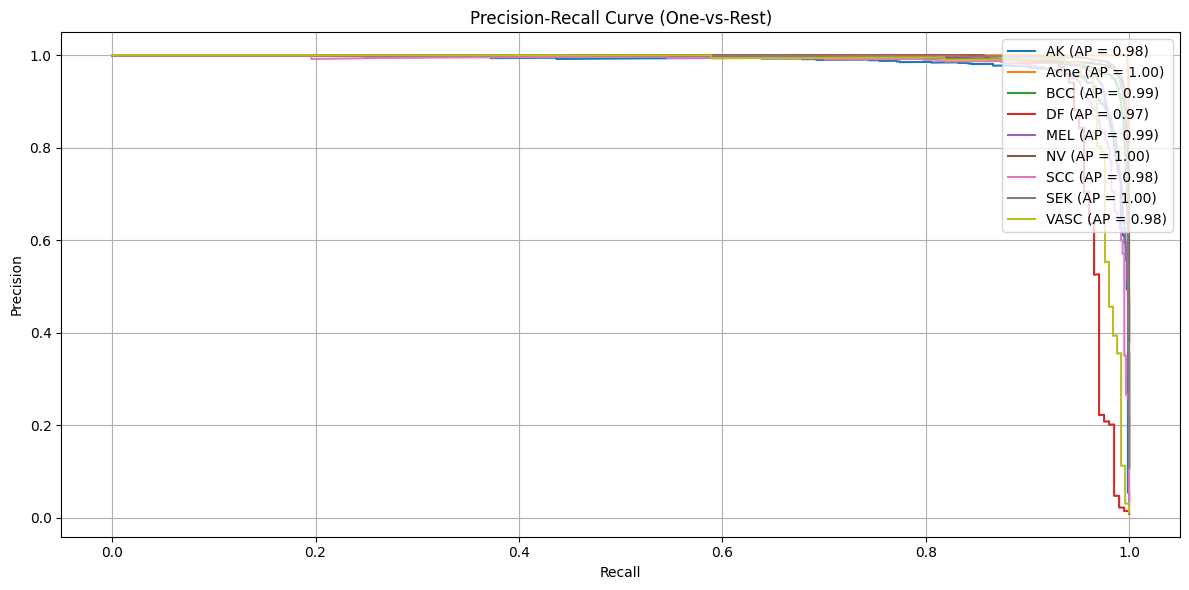

In [22]:
plot_roc_pr_curves(model, val_loader, class_names)


In [16]:
!pip install grad-cam timm

In [18]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
import timm
from torchvision import transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image

def apply_gradcam(image_path, model, target_layer, class_names=None):
    # Determine device from model parameters
    device = next(model.parameters()).device

    # Load and preprocess the image
    original_image = Image.open(image_path).convert('RGB')
    original_image = original_image.resize((299, 299))  # Resize to model's input size
    img_np = np.array(original_image) / 255.0  # Normalize image to [0,1]
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])
    input_tensor = transform(original_image).unsqueeze(0).to(device)  # Add batch dim and move to device

    # Predict and print the predicted class
    with torch.no_grad():
        output = model(input_tensor)
        pred_class_idx = output.argmax(dim=1).item()
    
    if class_names is not None:
        print(f"Predicted Class: {class_names[pred_class_idx]}")
    else:
        print(f"Predicted Class Index: {pred_class_idx}")

    # Initialize Grad-CAM
    cam = GradCAM(model=model, target_layers=[target_layer])

    # Generate the heatmap
    grayscale_cam = cam(input_tensor=input_tensor)[0]

    # Resize heatmap to match the original image size
    grayscale_cam_resized = cv2.resize(grayscale_cam, (299, 299))

    # Overlay the heatmap on the original image
    visualization = show_cam_on_image(img_np, grayscale_cam_resized, use_rgb=True)

    # Display the image with heatmap
    plt.imshow(visualization)
    plt.axis('off')
    plt.title("Grad-CAM Visualization")
    plt.show()


Predicted Class: AK


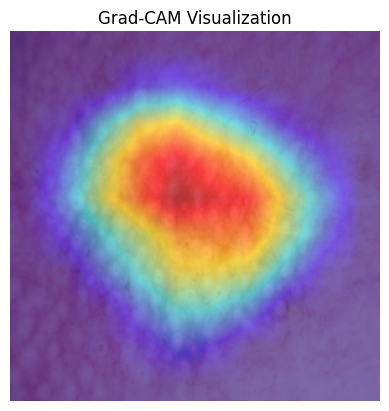

In [19]:
# Path to your sample image
image_path = '/kaggle/input/resized300sccaksekmelbccnvmeldermsekonly/resized/AK/ISIC_0024763.jpg'
# Define the target layer according to your model architecture
target_layer = model.model.conv4  # Adjust as needed

# List of class names (make sure the ordering corresponds to your model's output)
class_names = ['AK', 'Acne', 'BCC', 'DF', 'MEL', 'NV', 'SCC', 'SEK', 'VASC']

# Apply Grad-CAM and print prediction
apply_gradcam(image_path, model, target_layer, class_names)

Predicted Class: Acne


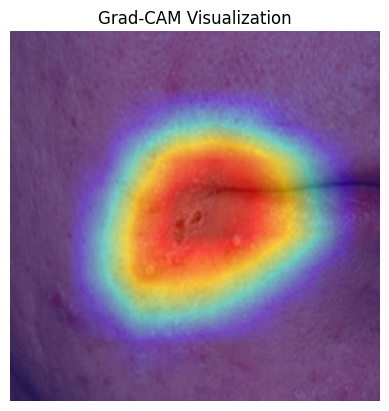

In [20]:
# Path to your sample image
image_path = '/kaggle/input/resized300sccaksekmelbccnvmeldermsekonly/resized/Acne/01F3MMV6NBB013AEV2SH04SRQ9_jpeg.rf.a88bc38371062a738c5591586ce56307.jpg'
# Define the target layer according to your model architecture
target_layer = model.model.conv4  # Adjust as needed

# List of class names (make sure the ordering corresponds to your model's output)
class_names = ['AK', 'Acne', 'BCC', 'DF', 'MEL', 'NV', 'SCC', 'SEK', 'VASC']

# Apply Grad-CAM and print prediction
apply_gradcam(image_path, model, target_layer, class_names)

In [ ]:
# Path to your sample image
image_path = '/kaggle/input/resized300sccaksekmelbccnvmeldermsekonly/resized/Acne/01F3MMV6NBB013AEV2SH04SRQ9_jpeg.rf.a88bc38371062a738c5591586ce56307.jpg'
# Define the target layer according to your model architecture
target_layer = model.model.conv4  # Adjust as needed

# List of class names (make sure the ordering corresponds to your model's output)
class_names = ['AK', 'Acne', 'BCC', 'DF', 'MEL', 'NV', 'SCC', 'SEK', 'VASC']

# Apply Grad-CAM and print prediction
apply_gradcam(image_path, model, target_layer, class_names)

Predicted Class: BCC


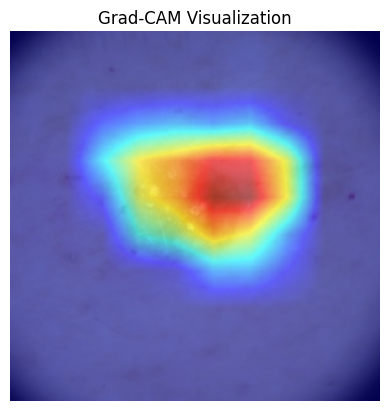

In [23]:
# Path to your sample image
image_path = '/kaggle/input/resized300sccaksekmelbccnvmeldermsekonly/resized/BCC/BCN_0000000070.jpg'
# Define the target layer according to your model architecture
target_layer = model.model.conv4  # Adjust as needed

# List of class names (make sure the ordering corresponds to your model's output)
class_names = ['AK', 'Acne', 'BCC', 'DF', 'MEL', 'NV', 'SCC', 'SEK', 'VASC']

# Apply Grad-CAM and print prediction
apply_gradcam(image_path, model, target_layer, class_names)

Predicted Class: DF


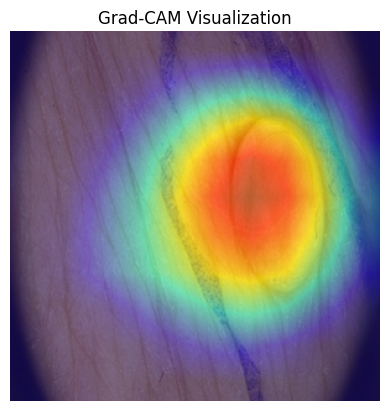

In [26]:
# Path to your sample image
image_path = '/kaggle/input/resized300sccaksekmelbccnvmeldermsekonly/resized/DF/0019_Dermatoscopic.jpg'
# Define the target layer according to your model architecture
target_layer = model.model.conv4  # Adjust as needed

# List of class names (make sure the ordering corresponds to your model's output)
class_names = ['AK', 'Acne', 'BCC', 'DF', 'MEL', 'NV', 'SCC', 'SEK', 'VASC']

# Apply Grad-CAM and print prediction
apply_gradcam(image_path, model, target_layer, class_names)

Predicted Class: MEL


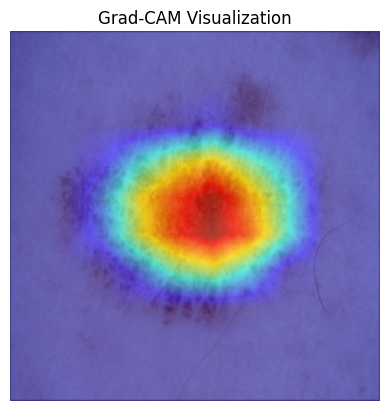

In [27]:
# Path to your sample image
image_path = '/kaggle/input/resized300sccaksekmelbccnvmeldermsekonly/resized/MEL/ISIC_0000022_downsampled.jpg'
# Define the target layer according to your model architecture
target_layer = model.model.conv4  # Adjust as needed

# List of class names (make sure the ordering corresponds to your model's output)
class_names = ['AK', 'Acne', 'BCC', 'DF', 'MEL', 'NV', 'SCC', 'SEK', 'VASC']

# Apply Grad-CAM and print prediction
apply_gradcam(image_path, model, target_layer, class_names)

Predicted Class: NV


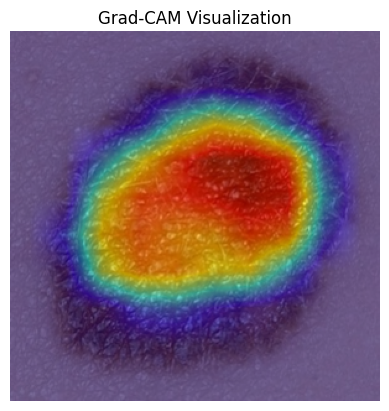

In [28]:
# Path to your sample image
image_path = '/kaggle/input/resized300sccaksekmelbccnvmeldermsekonly/resized/NV/156136.jpg'
# Define the target layer according to your model architecture
target_layer = model.model.conv4  # Adjust as needed

# List of class names (make sure the ordering corresponds to your model's output)
class_names = ['AK', 'Acne', 'BCC', 'DF', 'MEL', 'NV', 'SCC', 'SEK', 'VASC']

# Apply Grad-CAM and print prediction
apply_gradcam(image_path, model, target_layer, class_names)

Predicted Class: SCC


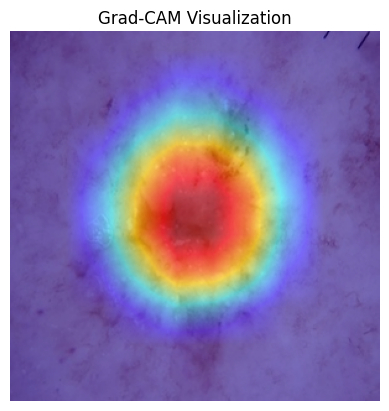

In [29]:
# Path to your sample image
image_path = '/kaggle/input/resized300sccaksekmelbccnvmeldermsekonly/resized/SCC/ISIC_0024372.jpg'
# Define the target layer according to your model architecture
target_layer = model.model.conv4  # Adjust as needed

# List of class names (make sure the ordering corresponds to your model's output)
class_names = ['AK', 'Acne', 'BCC', 'DF', 'MEL', 'NV', 'SCC', 'SEK', 'VASC']

# Apply Grad-CAM and print prediction
apply_gradcam(image_path, model, target_layer, class_names)

Predicted Class: SEK


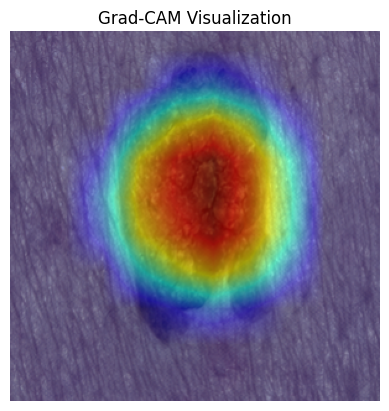

In [30]:
# Path to your sample image
image_path = '/kaggle/input/resized300sccaksekmelbccnvmeldermsekonly/resized/SEK/0004_TotalFocus.png'
# Define the target layer according to your model architecture
target_layer = model.model.conv4  # Adjust as needed

# List of class names (make sure the ordering corresponds to your model's output)
class_names = ['AK', 'Acne', 'BCC', 'DF', 'MEL', 'NV', 'SCC', 'SEK', 'VASC']

# Apply Grad-CAM and print prediction
apply_gradcam(image_path, model, target_layer, class_names)

Predicted Class: VASC


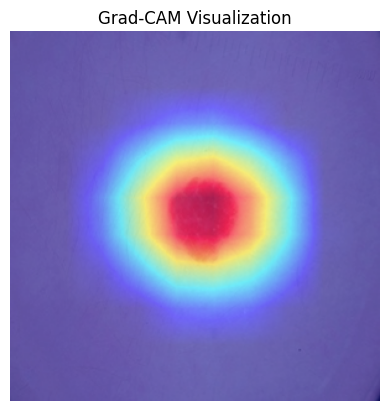

In [31]:
# Path to your sample image
image_path = '/kaggle/input/resized300sccaksekmelbccnvmeldermsekonly/resized/VASC/ISIC_0024402.jpg'
# Define the target layer according to your model architecture
target_layer = model.model.conv4  # Adjust as needed

# List of class names (make sure the ordering corresponds to your model's output)
class_names = ['AK', 'Acne', 'BCC', 'DF', 'MEL', 'NV', 'SCC', 'SEK', 'VASC']

# Apply Grad-CAM and print prediction
apply_gradcam(image_path, model, target_layer, class_names)